[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Yo18y5sNM00HKRIhsJI-mDjPPJTnvpld)


## <center> "Прогнозирование бронирований на AirBnB" </center>


**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data).

#### Импортируем необходимые библиотеки

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import make_scorer
from scipy.sparse import csr_matrix, hstack, vstack
import pickle
from sklearn.model_selection import learning_curve
import json
import getpass

%matplotlib inline
# figure size in inches
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
plt.rcParams['figure.figsize'] = 16,9

In [0]:
def create_submission(predict, id_vals, enc, filename):
    # Для каждого ID пользователя отбираем 5 классов с максимальной предсказанной вероятностью
    ids = []  # спикок ID пользователей
    cts = []  # список стран
    for i in range(len(id_vals)):
        idx = id_vals[i]
        ids += [idx] * 5
        cts += enc.inverse_transform(np.argsort(predict[i])[::-1])[:5].tolist()
    #Generate submission
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(filename, index=False) 

In [0]:
# Реализация вычисления целевой метрики NDCG
def my_ndcg(y_true, y_predict, k=5):
    ndcg = 0
    n = 0
    for y_true_val, y_predict_vec in zip(y_true, y_predict):
        #print(y_true_val, y_predict_vec)
        order = np.argsort(y_predict_vec)[::-1][:k]
        #print(order)
        for idx, y_predict_val in enumerate(order):
            if y_true_val == y_predict_val:
                #print(1 / np.log2(idx + 2))
                ndcg += 1 / np.log2(idx + 2)
                break
        n += 1
    #print(ndcg)
    return ndcg / n

In [0]:
ndcg_scorer = make_scorer(my_ndcg, needs_proba=True, k=5)

###  Часть 1. Описание набора данных и признаков

#### Введение

AirBnB - это онлайн-площадка для размещения, поиска и краткосрочной аренды частного жилья по всему миру. Пользователи Airbnb имеют возможность сдавать путешественникам в аренду своё жильё целиком или частично. Сайт предоставляет платформу для установления контакта между хозяином и гостем, а также отвечает за обработку транзакций.

Данный индивидуальный проект посвящен задаче прогнозирования страны первого бронирования жилья для новых пользователей AirBnb (*задача многоклассовой классификации*). Ценность этой задачи для бизнеса состоит в том, что правильное прогнозирование места первого бронирования позволит делать пользователям персонализированные предложения (баннеры на сайте, рассылка по почте). Это в свою очередь должно снизить среднее время от регистрации нового пользователя до первого бронирования, что повысит конверсию пользователей и благотворно скажется на финансовом результате компании.

#### Описание набора данных и признаков

Набор данных получен из Kaggle ([Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data)) и включает несколько файлов с данными о пользователях (вкл. социально-демографические данные) и пользовательских веб-сессиях:
* *train_users.csv* - обучающая выборка данных о пользователях.

|               Переменная | Описание |
|--------------------------|----------|
|                       id | ID пользователя |
|     date_account_created | Дата создания аккаунта на airbnb |
|   timestamp_first_active | Дата и время первой активности на сайте airbnb.com |
|       date_first_booking | Дата первого бронирования |
|                   gender | Пол |
|                      age | Возраст |
|            signup_method | Способ регистрации (базовый, профиль facebook или google) |
|              signup_flow | Страница, с которой пользователь перешел для регистрации |
|                 language | Предпочитаемый язык |
|        affiliate_channel | Тип рекламы |
|       affiliate_provider | Провайдер рекламы |
|  first_affiliate_tracked | Первый тип рекламы, с которым взаимодействовал пользователь перед регистрацией |
|               signup_app | Приложение, с которого была регистрация |
|        first_device_type | Тип первого девайса пользователя |
|            first_browser | Первый браузер пользователя |
|  **country_destination** | **Целевая переменная** - страна первого бронирования |

* *test_users.csv* - тестовая выборка данных о пользователях. Структура аналогична train_users.csv за исключением отсутсвия целевой переменной country_destination.

* *sessions.csv* - данные о web-сессиях пользователей (клики, обновление wish-листов, поиск и др.). Будет использоваться для обогащения основных признаков по пользоватлям.

|               Переменная |          Описание |
|--------------------------|-------------------|
|                       id |   ID пользователя |
|                   action | Действие на сайте |
|              action_type | Тип действия |
|            action_detail | Детализация действия |
|            device_type | Тип девайса |
|            secs_elapsed | Длительность действия |


#### Общие замечания по исходным данным

* Все пользователи в предоставленных данных из США.
* Имеются 12 возможных значений целевой переменной - страны первого бронирования: US (США), FR (Франция), CA (Канада), GB (Великобритания), ES (Испания), IT (Италия), PT (Португалия), NL (Нидерланды), DE (Германия), AU (Австралия), NDF (no destination found), and 'other' (другое).
* 'other' (другое) - означает, что пользователь сделал бронирование, но страна бронирования не входит в приведенный выше список. А 'NDF' означает, что первого бронирования не было.
* Тестовые и обучающие наборы данных не пересекаются по датам. В тестовом наборе данных нужно спрогнозироать страну первого бронирования для пользователей, у которых первые активности на airbnb (регистрация, поиск, клики) состоялись после 01.07.2014.

###  Часть 2. Первичный анализ признаков

#### Загружаем исходные данные

In [0]:
login = None
password = None
while(not(login and password)):
  login = input("Login [%s]: " % getpass.getuser())
  password = getpass.getpass('Password:')

Login [root]: marat210499@yandex.ru
Password:··········


In [0]:
!pip install kaggle-cli
!kg config -g -u $login -p $password -c airbnb-recruiting-new-user-bookings
!kg download

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/download/countries.csv.zip

countries.csv.zip already downloaded !
downloading https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/download/age_gender_bkts.csv.zip

age_gender_bkts.csv.zip already downloaded !
downloading https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/download

In [0]:
!unzip -n \*.zip

Archive:  age_gender_bkts.csv.zip

Archive:  train_users_2.csv.zip

Archive:  countries.csv.zip

Archive:  sample_submission_NDF.csv.zip

Archive:  test_users.csv.zip

Archive:  sessions.csv.zip

6 archives were successfully processed.


In [0]:
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')

In [0]:
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

Итак, у нас имеются данные по *213451* пользователям в обучающей выборке и *62096* пользователям в тестовой.

#### Первичный осмотр данных

In [0]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [0]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


Выводы по первичному осмотру данных:
* По крайней мере в двух признаках (date_first_booking и age) есть пропуски. Далее мы исследуем этот вопрос подробнее.
* В наборе данных очень много категориальных признаков. Соответственно, далее их нужно будет преобразовывать.
* Признак timestamp_first_active нужно преобразовать к нормальному типу timestamp.

In [0]:
# Создадим объединенный набор данных - будет полезно для некоторых дальнейших исследований
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
# Удалим из объединенного датасета ID пользователя - он пока не нужен
df_all.drop('id', axis=1, inplace=True)

In [0]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
country_destination        213451 non-null object
date_account_created       275547 non-null object
date_first_booking         88908 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              275547 non-null object
first_device_type          275547 non-null object
gender                     275547 non-null object
language                   275547 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(12)
memory usage: 31.5+ MB


#### Профилирование категориальных переменных

В нашем наборе данных много категориальных переменных. Давайте исследуем распределение их значений.

In [0]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [0]:
for cat_feat in categorical_features:
    heading = "Profile for {}".format(cat_feat)
    print("*" * len(heading))
    print(heading)
    print("*" * len(heading))
    print(df_all[cat_feat].value_counts())
    print("\n")

*****************************
Profile for affiliate_channel
*****************************
direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64


******************************
Profile for affiliate_provider
******************************
direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64


****

Замечания по результатам профилирования категориальных признаков:
* В некоторых признаках встречаются значения -unknown- - это очевидно пропущенные значению. Нужно принять это во внимание при очистке данных.
* Распределение целевой переменной говорит о том, что подавляющее большинство пользователей (по факту 90%) попадает в две категории - они либо еще не сделали бронирование, либо сделали первое бронирование в США. На это стоит обратить внимание при моделировании, т.к. сильно обобщенная модель может выдавать только два прогноза - NDF и USA.

#### Переменная возраст (Age)

In [0]:
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [0]:
df_all.age.min()

1.0

In [0]:
df_all.age.max()

2014.0

In [0]:
df_all.age.value_counts()

30.0      7712
28.0      7687
29.0      7647
31.0      7540
27.0      7462
32.0      7187
33.0      6795
26.0      6745
34.0      6176
25.0      6149
35.0      5949
36.0      5032
24.0      4571
37.0      4474
38.0      4091
39.0      3642
23.0      3516
40.0      3327
41.0      3098
42.0      2731
45.0      2669
44.0      2584
22.0      2508
43.0      2486
46.0      2317
19.0      2023
47.0      2006
48.0      1779
50.0      1679
51.0      1630
          ... 
1949.0       3
1936.0       2
1920.0       2
111.0        2
1938.0       2
1929.0       2
1923.0       2
1926.0       2
1944.0       2
1951.0       2
1940.0       2
1942.0       1
2002.0       1
150.0        1
1952.0       1
1945.0       1
2008.0       1
1939.0       1
2000.0       1
1995.0       1
1948.0       1
1968.0       1
1930.0       1
1941.0       1
1922.0       1
1954.0       1
1953.0       1
132.0        1
1937.0       1
112.0        1
Name: age, Length: 145, dtype: int64

Мы видим, что в переменной age встречаются странные значения - больше 120 и меньше 10.

In [0]:
sum(df_all.age > 120)

830

In [0]:
sum(df_all.age < 10)

59

На этапе предобработки такие данные потребуют особого внимания.

#### Пропущенные значения

Для более объективной картины по пропущенным значениям заменим значения '-unknown-' в некоторых категориальных признаках на стандартное неопределенное значение np.nan.

In [0]:
df_all.gender.replace('-unknown-', np.nan, inplace=True)
df_train.gender.replace('-unknown-', np.nan, inplace=True)
df_test.gender.replace('-unknown-', np.nan, inplace=True)

df_all.language.replace('-unknown-', np.nan, inplace=True)
df_train.language.replace('-unknown-', np.nan, inplace=True)
df_test.language.replace('-unknown-', np.nan, inplace=True)

df_all.first_browser.replace('-unknown-', np.nan, inplace=True)
df_train.first_browser.replace('-unknown-', np.nan, inplace=True)
df_test.first_browser.replace('-unknown-', np.nan, inplace=True)

Проведем исследование пропущенных значений отдельно для обучающей и тестовой выборки.

In [0]:
df_train_missing = df_train.isnull().sum() / df_train.shape[0]
df_train_missing[df_train_missing > 0]

date_first_booking         0.583473
gender                     0.448290
age                        0.412226
first_affiliate_tracked    0.028414
first_browser              0.127739
dtype: float64

In [0]:
df_test_missing = df_test.isnull().sum() / df_test.shape[0]
df_test_missing[df_test_missing > 0].drop('date_first_booking')

gender                     0.544190
age                        0.465022
language                   0.000016
first_affiliate_tracked    0.000322
first_browser              0.275831
dtype: float64

В наших данных много пропусков в переменных gender, age, date_first_booking и first_browser. 
Переменная date_first_booking связана с целевой переменной и ее пропуски обусловлены значением NDF целевой переменной. По остальным переменным с пропусками нужно будет выбрать стратегии обработки.

###  Часть 3. Первичный визуальный анализ признаков

#### Распределение целевой переменной

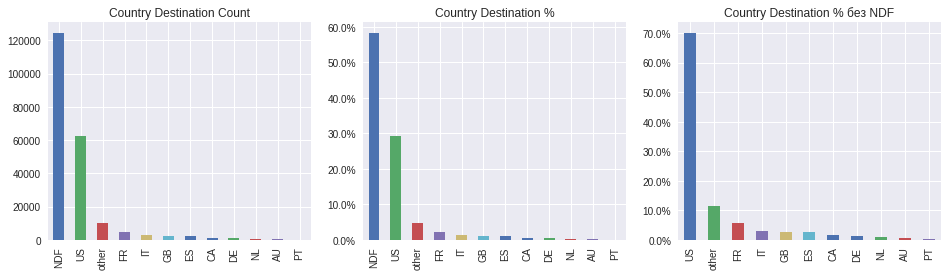

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

country_counts = df_train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count', ax=axes[0])

ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])

booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % без NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()]);

Графики подтверждают наши наблюдения, сделанные ранее - большая часть значений целевой переменной относятся к двум классам - NDF (не сделавшие бронирование) и USA.

#### Распределение целевой переменной с учетом пола

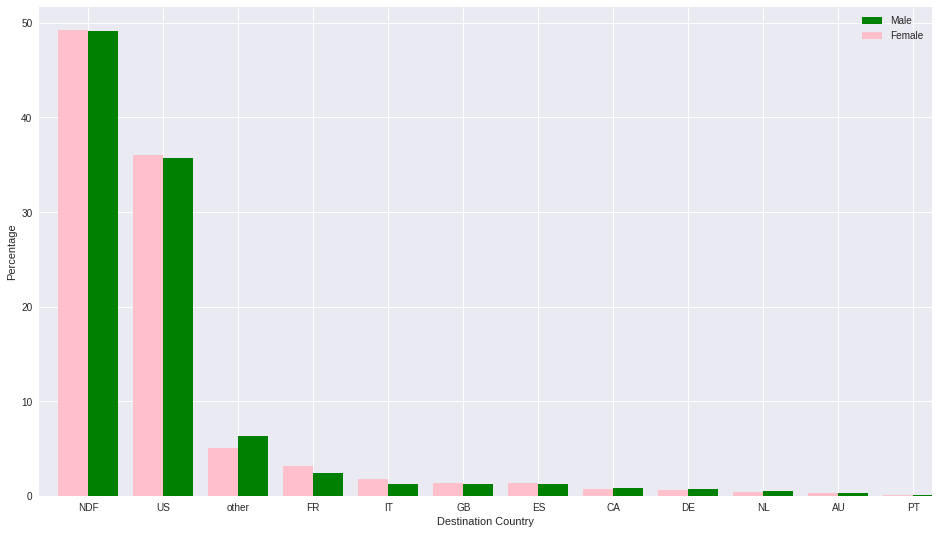

In [0]:
women = sum(df_train['gender'] == 'FEMALE')
men = sum(df_train['gender'] == 'MALE')

female_destinations = df_train[df_train['gender'] == 'FEMALE'].country_destination.value_counts() / women * 100
male_destinations = df_train[df_train['gender'] == 'MALE'].country_destination.value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='green', position=0, label='Male', rot=0, figsize=(16, 9))
female_destinations.plot(kind='bar', width=width, color='pink', position=1, label='Female', rot=0, figsize=(16, 9))

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Судя по графику, практически нет различий в предпочтениях мужчин и женщин.

#### Распределение целевой переменной с учетом возраста

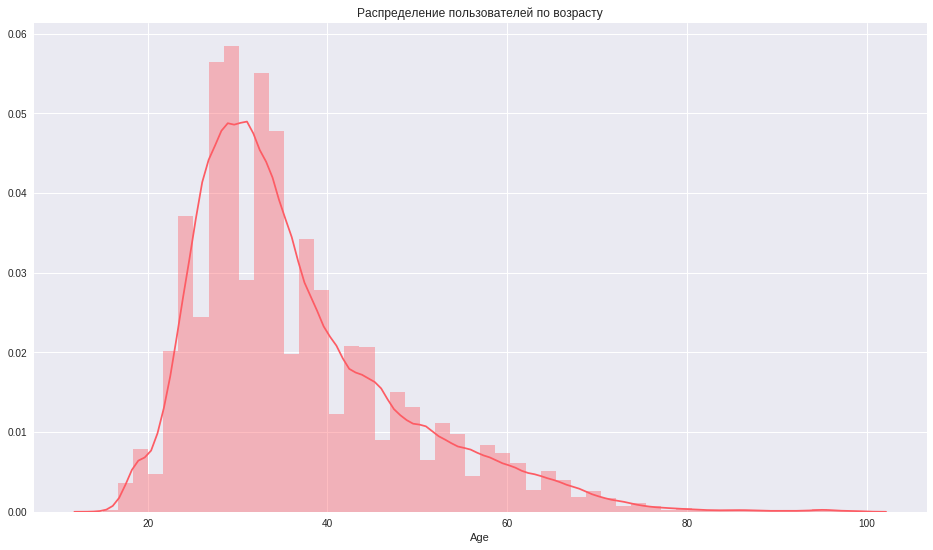

In [0]:
sns.distplot(df_train[(df_train.age < 100)&(df_train.age > 10)].age.dropna(), color='#FD5C64')
plt.title("Распределение пользователей по возрасту")
#plt.figsize = (16, 9)
plt.xlabel('Age')
plt.rcParams['figure.figsize'] = 16,9

AirBnb наиболее популярен среди пользователей от 25 до 40 лет.

In [0]:
age_data = df_train[(df_train.age < 100)&(df_train.age > 10)]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


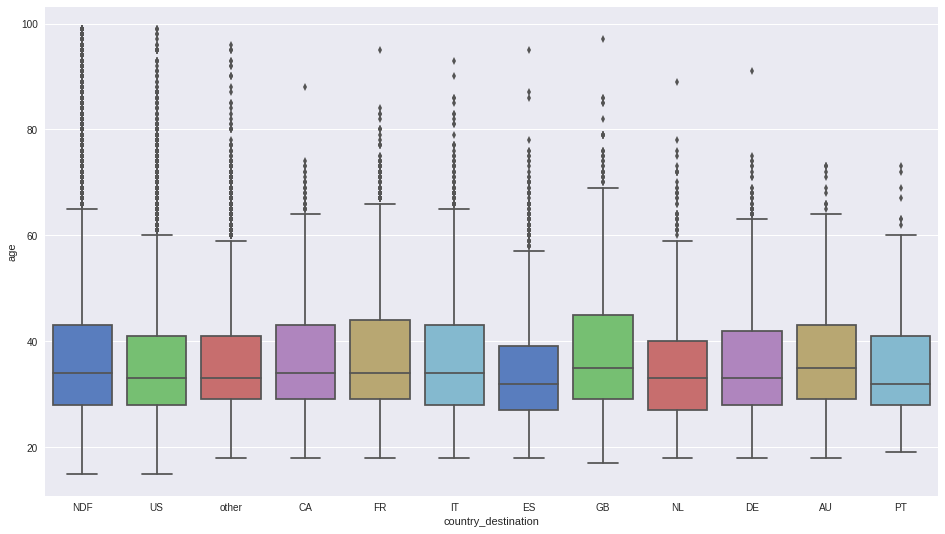

In [0]:
sns.boxplot(x='country_destination', y='age', data=age_data, palette="muted");

На этом графике не видно больших различий бронирования в зависимости от возраста пользователя.

Попробуем посмотреть на распределение целевой переменной по возрасту на двух частях выборки, разделенных медианой.

In [0]:
age_data.age.median()

34.0

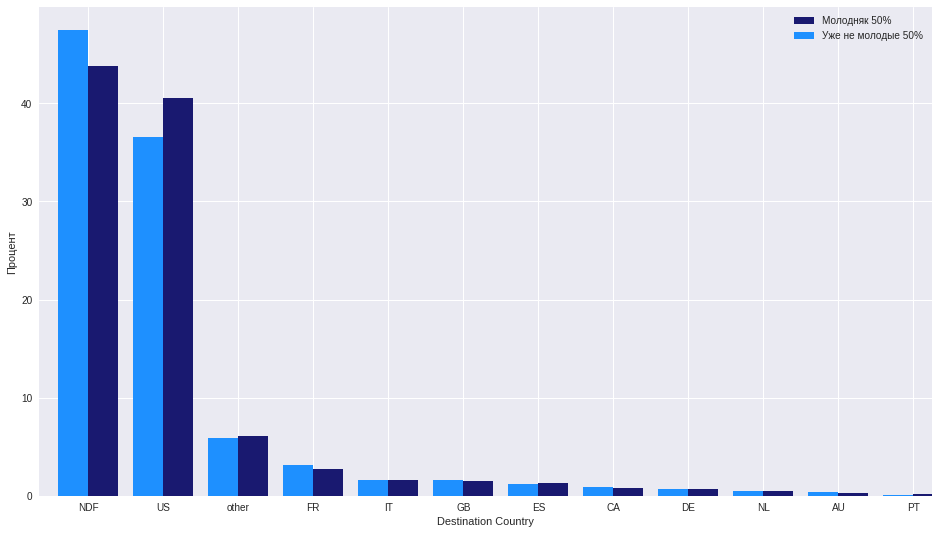

In [0]:
age = age_data.age.median()

younger = sum(age_data['age'] < age)
older = sum(age_data['age'] > age)

younger_destinations = age_data[age_data['age'] < age].country_destination.value_counts() / younger * 100
older_destinations = age_data[age_data['age'] > age].country_destination.value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#191970', position=0, label='Молодняк 50%', rot=0)
older_destinations.plot(kind='bar', width=width, color='#1E90FF', position=1, label='Уже не молодые 50%', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Процент')

sns.despine()
plt.show()

На этом графике видно, что "более молодая" половина делает чаще первое бронирование после регистрации (меньше доля NDF) и в то же время чаще делает бронирование в США.

#### Временные признаки

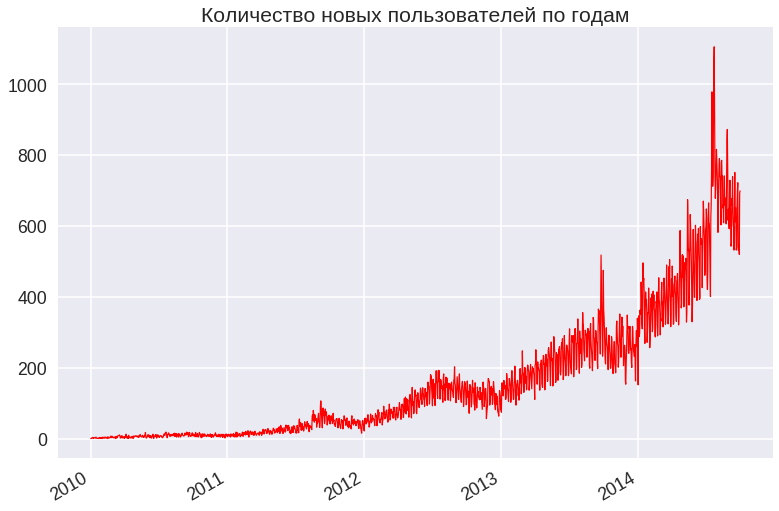

In [0]:
sns.set_style("darkgrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all.date_account_created.value_counts().sort_index().plot(kind='line', linewidth=1.2, color='red',)
plt.title("Количество новых пользователей по годам");

Мы видим экспоненциальный рост количества пользователей по времени.

###  Часть 4. Закономерности, "инсайты", особенности данных

Выше вы уже отмечали найденные особенности в данных. Соберем их здесь вместе:
* Распределение целевой переменной говорит о том, что подавляющее большинство пользователей (по факту 90%) попадает в две категории - они либо еще не сделали бронирование, либо сделали первое бронирование в США. На это стоит обратить внимание при моделировании, т.к. сильно обобщенная модель может выдавать только два прогноза - NDF и USA.
* Мы видим экспоненциальный рост количества пользователей по времени. Причем скорость роста усиливается с 2014 года. Возможно имеет смысл использовать для моделирования более свежие данные (начиная с 2014 года).
* В данных довольно много пропусков (и некорректных значений) по полу и возрасту. Часть некорректных значений по возрасту можно будет восстановить, т.к. некоторые пользователи вместо возраста ввели год рождения (например, 1951). Пропущенные значения связаны, скорее всего, с нежеланием пользователей раскрывать свои личные данные.
* Мы не обнаружили различий в распределении целевой переменной по полу и возрасту. Для моделирования потребуется более глубокий анализ и создание новых признаков.
* Пользователи с возрастом меньше медианного (половина выборки) более часто делают первое бронирование, чем вторая половина пользователей.
* Переменная date_first_booking связана с целевой переменной и заполнена только в обучающей выборке. Она не может быть использована для обучения модели, поэтому ее следует удалить из обучающей выборки.

###  Часть 5. Предобработка данных 

#### Скорректируем форматы переменных, связанных с датами и временем

In [0]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])

df_train['timestamp_first_active'] = pd.to_datetime(df_train['timestamp_first_active'], format='%Y%m%d%H%M%S')
df_test['timestamp_first_active'] = pd.to_datetime(df_test['timestamp_first_active'], format='%Y%m%d%H%M%S')

Переменная date_first_booking связана с целевой переменной и заполнена только в обучающей выборке, поэтому ее следует удалить:

In [0]:
df_train.drop('date_first_booking', axis=1, inplace=True)
df_test.drop('date_first_booking', axis=1, inplace=True)

#### Обработка переменной Age

Часть пользователей ввели год рождения вместо возраста. Попробуем восстановить их возраст.

In [0]:
train_with_year_age_mask = df_train['age'] > 1900
df_train.loc[train_with_year_age_mask, 'age'] = 2015 - df_train.loc[train_with_year_age_mask, 'age'] # соревнование 2015г

In [0]:
test_with_year_age_mask = df_test['age'] > 1900
df_test.loc[test_with_year_age_mask, 'age'] = 2015 - df_test.loc[test_with_year_age_mask, 'age']

Значения возраста больше 100 считаем некорректными и присваиваем им неопределенное значение.

In [0]:
df_train.loc[df_train.age >= 100, 'age'] = np.nan
df_test.loc[df_test.age >= 100, 'age'] = np.nan

Аналогично поступаем со значениями возраста менее 15.

In [0]:
df_train.loc[df_train.age <= 15, 'age'] = np.nan
df_test.loc[df_test.age <= 15, 'age'] = np.nan

Все пропуски в возрасте заполняем -1.

In [0]:
df_train['age'].fillna(-1, inplace=True)
df_test['age'].fillna(-1, inplace=True)

In [0]:
df_train['age'] = df_train['age'].astype(int)
df_test['age'] = df_test['age'].astype(int)

#### Обработка остальных пропусков

Для категориальных переменных с пропущенными значениями преобразуем пропуски к 'unknown' для того, чтобы потом сработал LabelBinarizer.

In [0]:
df_train['first_affiliate_tracked'].fillna('unknown', inplace=True)
df_test['first_affiliate_tracked'].fillna('unknown', inplace=True)
              
df_train['first_browser'].fillna('unknown', inplace=True)
df_test['first_browser'].fillna('unknown', inplace=True)

df_train['language'].fillna('unknown', inplace=True)
df_test['language'].fillna('unknown', inplace=True)

df_train['gender'].fillna('unknown', inplace=True)
df_test['gender'].fillna('unknown', inplace=True)

###  Часть 6. Создание новых признаков и описание этого процесса

#### Добавим признаки, связанные с сессиями пользователя

In [0]:
%%time
df_sessions = pd.read_csv('sessions.csv')

CPU times: user 10.5 s, sys: 838 ms, total: 11.3 s
Wall time: 11.3 s


In [0]:
df_sessions.shape

(10567737, 6)

In [0]:
df_sessions.head(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


Выдвинем гипотезу, что пользоватали, которые чаще пользуются airbnb с мобильного устройства, чаще бронируют жилье в родной стране. Соответственно будет полезно узнать основной используемый девайс в разрезе пользователя.

In [0]:
# Определяем основной девайс пользователя
sessions_device = df_sessions.loc[:, ['user_id', 'device_type', 'secs_elapsed']]
aggregated_lvl1 = sessions_device.groupby(['user_id', 'device_type'], as_index=False, sort=False).aggregate(np.sum)
idx = aggregated_lvl1.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == aggregated_lvl1['secs_elapsed']
df_primary = pd.DataFrame(aggregated_lvl1.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_primary.rename(columns = {'device_type':'primary_device', 'secs_elapsed':'primary_secs'}, inplace=True)

df_primary = pd.concat([df_primary[['user_id', 'primary_secs']], 
                        pd.get_dummies(df_primary['primary_device'], 
                                       prefix='prima')
                       ], axis=1)
df_primary.columns = [col.replace('-', '').replace(' ', '_').lower() for col in df_primary.columns]

In [0]:
df_primary.shape

(135483, 16)

Также определим второй по популярности девайс в разрезе пользователя

In [0]:
# Определяем второй девайс пользователя
remaining = aggregated_lvl1.drop(aggregated_lvl1.index[idx])
idx = remaining.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == remaining['secs_elapsed']
df_secondary = pd.DataFrame(remaining.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_secondary.rename(columns = {'device_type':'secondary_device', 'secs_elapsed':'secondary_secs'}, inplace=True)


df_secondary = pd.concat([df_secondary[['user_id', 'secondary_secs']], 
                        pd.get_dummies(df_secondary['secondary_device'], 
                                       prefix='second')
                       ], axis=1)
df_secondary.columns = [col.replace('-', '').replace(' ', '_').lower() for col in df_secondary.columns]
#df_secondary = convert_to_binary(df=df_secondary, column_to_convert='secondary_device')
#df_secondary.drop('secondary_device', axis=1, inplace=True)

In [0]:
df_secondary.shape

(36521, 16)

Дополнительно рассчитаем фичи на основе агрегации различных типов событий из пользовательских сессий.

In [0]:
# Вспомогательная функция для расчета агрегатов по типам событий в разрезе клиентов и разворачивания (pivot) типов по столбцам 
def convert_to_counts(df, id_col, column_to_convert):
    id_list = df[id_col].drop_duplicates()

    df_counts = df.loc[:,[id_col, column_to_convert]]
    df_counts['count'] = 1
    df_counts = df_counts.groupby(by=[id_col, column_to_convert], as_index=False, sort=False).sum()

    new_df = df_counts.pivot(index=id_col, columns=column_to_convert, values='count')
    new_df = new_df.fillna(0)

    
    categories = list(df[column_to_convert].drop_duplicates())
    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert + '_' + cat_name
        new_df.rename(columns = {category:col_name}, inplace=True)

    return new_df

In [0]:
%%time
print("Aggregating actions taken...")
session_actions = df_sessions.loc[:, ['user_id', 'action', 'action_type', 'action_detail']]
columns_to_convert = ['action', 'action_type', 'action_detail']
session_actions = session_actions.fillna('not provided')
first = True

for column in columns_to_convert:
    
    print("Converting " + column + " column...")
    current_data = convert_to_counts(df=session_actions, id_col='user_id', column_to_convert=column)
    
    # If first loop, current data becomes existing data, otherwise merge existing and current
    if first:
        first = False
        actions_data = current_data
    else:
        actions_data = pd.concat([actions_data, current_data], axis=1, join='inner')

Aggregating actions taken...
Converting action column...
Converting action_type column...
Converting action_detail column...
CPU times: user 55.7 s, sys: 2.14 s, total: 57.9 s
Wall time: 57.9 s


In [0]:
actions_data.shape

(135484, 527)

#### Объединим признаки сессий с обучающей и тестовой выборками

In [0]:
# Сначала объединим датасеты с девайсами...
df_primary.set_index('user_id', inplace=True)
df_secondary.set_index('user_id', inplace=True)
device_data = pd.concat([df_primary, df_secondary], axis=1, join="outer")

# ...затем к девайсам добавим события
combined_results = pd.concat([device_data, actions_data], axis=1, join='outer')
df_sessions = combined_results.fillna(0)

In [0]:
primary_cols = [col for col in df_primary.columns if col != 'primary_secs']
secondary_cols = [col for col in df_secondary.columns if col != 'secondary_secs']

In [0]:
df_sessions.shape

(135484, 557)

In [0]:
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

In [0]:
#df_train_sessions = pd.DataFrame(index=df_train['id'])
#df_test_sessions = pd.DataFrame(index=df_test['id'])

In [0]:
df_train = df_train.join(df_sessions, how='inner')
df_test = df_test.join(df_sessions, how='left')

In [0]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [0]:
df_train.shape, df_test.shape

((73815, 571), (62096, 570))

#### Выделяем целевую переменную

In [0]:
y_enc = LabelEncoder()

In [0]:
# Текстовые значения классов (стран) нужно перекодировать в числовые
y = y_enc.fit_transform(df_train[['country_destination']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
y.shape

(73815,)

In [0]:
import pickle
pickle.dump(y_enc, open('y_enc.dump', 'wb'))

In [0]:
#Сохраняем
np.savetxt("train_target.csv", y, delimiter=",")

In [0]:
df_train.drop('country_destination', axis=1, inplace=True)

In [0]:
categorical_features.remove('country_destination')

#### Перекодируем текстовые категориальные переменные

In [0]:
# Так как на входе у нах текстовые значения, то используем LabelBinarizer вместо OneHotEncoder
lab_enc = LabelBinarizer(sparse_output=True)

LabelBinarizer умеет кодировать только один признак за раз...

In [0]:
X_train_affiliate_channel_bin = lab_enc.fit_transform(df_train['affiliate_channel'])
X_test_affiliate_channel_bin = lab_enc.transform(df_test['affiliate_channel'])

In [0]:
X_train_affiliate_provider_bin = lab_enc.fit_transform(df_train['affiliate_provider'])
X_test_affiliate_provider_bin = lab_enc.transform(df_test['affiliate_provider'])

In [0]:
X_train_first_affiliate_tracked_bin = lab_enc.fit_transform(df_train['first_affiliate_tracked'])
X_test_first_affiliate_tracked_bin = lab_enc.transform(df_test['first_affiliate_tracked'])

In [0]:
X_train_first_browser_bin = lab_enc.fit_transform(df_train['first_browser'])
X_test_first_browser_bin = lab_enc.transform(df_test['first_browser'])

In [0]:
X_train_first_device_type_bin = lab_enc.fit_transform(df_train['first_device_type'])
X_test_first_device_type_bin = lab_enc.transform(df_test['first_device_type'])

In [0]:
X_train_gender_bin = lab_enc.fit_transform(df_train['gender'])
X_test_gender_bin = lab_enc.transform(df_test['gender'])

In [0]:
X_train_language_bin = lab_enc.fit_transform(df_train['language'])
X_test_language_bin = lab_enc.transform(df_test['language'])

In [0]:
X_train_signup_app_bin = lab_enc.fit_transform(df_train['signup_app'])
X_test_signup_app_bin = lab_enc.transform(df_test['signup_app'])

In [0]:
X_train_signup_method_bin = lab_enc.fit_transform(df_train['signup_method'])
X_test_signup_method_bin = lab_enc.transform(df_test['signup_method'])

#### Выделяем признаки, связанные с датами и временем

In [0]:
df_train['weekday_account_created'] = df_train.date_account_created.dt.weekday
df_test['weekday_account_created'] = df_test.date_account_created.dt.weekday
df_train['day_account_created'] = df_train.date_account_created.dt.day
df_test['day_account_created'] = df_test.date_account_created.dt.day
df_train['month_account_created'] = df_train.date_account_created.dt.month
df_test['month_account_created'] = df_test.date_account_created.dt.month
df_train['quarter_account_created'] = df_train.date_account_created.dt.quarter
df_test['quarter_account_created'] = df_test.date_account_created.dt.quarter
df_train['year_account_created'] = df_train.date_account_created.dt.year
df_test['year_account_created'] = df_test.date_account_created.dt.year

In [0]:
df_train['hour_first_active'] = df_train.timestamp_first_active.dt.hour
df_test['hour_first_active'] = df_test.timestamp_first_active.dt.hour
df_train['weekday_first_active'] = df_train.timestamp_first_active.dt.weekday
df_test['weekday_first_active'] = df_test.timestamp_first_active.dt.weekday
df_train['day_first_active'] = df_train.timestamp_first_active.dt.day
df_test['day_first_active'] = df_test.timestamp_first_active.dt.day
df_train['month_first_active'] = df_train.timestamp_first_active.dt.month
df_test['month_first_active'] = df_test.timestamp_first_active.dt.month
df_train['quarter_first_active'] = df_train.timestamp_first_active.dt.quarter
df_test['quarter_first_active'] = df_test.timestamp_first_active.dt.quarter
df_train['year_first_active'] = df_train.timestamp_first_active.dt.year
df_test['year_first_active'] = df_test.timestamp_first_active.dt.year

In [0]:
df_train['time_lag'] = (df_train['date_account_created'] - df_train['timestamp_first_active']).dt.days
df_test['time_lag'] = (df_test['date_account_created'] - df_test['timestamp_first_active']).dt.days

#### Перекодируем числовые категориальные переменные

In [0]:
oh_enc = OneHotEncoder(handle_unknown='ignore')

In [0]:
X_train_cat_bin = oh_enc.fit_transform(df_train[['signup_flow', 
                                                'weekday_account_created', 
                                                'day_account_created', 
                                                'month_account_created', 
                                                'quarter_account_created', 
                                                'year_account_created', 
                                                'hour_first_active', 
                                                'weekday_first_active', 
                                                'day_first_active', 
                                                'month_first_active', 
                                                'quarter_first_active', 
                                                'year_first_active']])

X_test_cat_bin = oh_enc.transform(df_test[['signup_flow', 
                                           'weekday_account_created', 
                                           'day_account_created', 
                                           'month_account_created', 
                                           'quarter_account_created', 
                                           'year_account_created', 
                                           'hour_first_active', 
                                           'weekday_first_active', 
                                           'day_first_active', 
                                           'month_first_active', 
                                           'quarter_first_active', 
                                           'year_first_active']])

In [0]:
X_train_cat_bin.shape, X_test_cat_bin.shape
# ((213451, 160), (62096, 160))

((73815, 125), (62096, 125))

#### Масштабирование признаков

Так как мы планируем попробовать в т.ч. линейные модели, то необходимо масштабирование признаков.

In [0]:
scaler = StandardScaler()
X_train_age_scaled = scaler.fit_transform(df_train[['age']])
X_test_age_scaled = scaler.transform(df_test[['age']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
X_train_time_lag_scaled = scaler.fit_transform(df_train[['time_lag']])
X_test_time_lag_scaled = scaler.transform(df_test[['time_lag']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [0]:
X_train_primary_secs_scaled = scaler.fit_transform(df_train[['primary_secs']])
X_test_primary_secs_scaled = scaler.transform(df_test[['primary_secs']])

In [0]:
X_train_actions_scaled = scaler.fit_transform(df_train[actions_data.columns])
X_test_actions_scaled = scaler.transform(df_test[actions_data.columns])

#### Объединим все созданные признаки в единый датасет

In [0]:
X_train = csr_matrix(
            hstack(
                [X_train_affiliate_channel_bin,
                 X_train_affiliate_provider_bin,
                 X_train_first_affiliate_tracked_bin,
                 X_train_first_browser_bin,
                 X_train_first_device_type_bin,
                 X_train_gender_bin,
                 X_train_language_bin,
                 X_train_signup_app_bin,
                 X_train_signup_method_bin,
                 X_train_cat_bin,
                 X_train_age_scaled,
                 X_train_time_lag_scaled,
                 X_train_actions_scaled,
                 df_train[primary_cols]
                ]
            )
)

In [0]:
X_test = csr_matrix(
            hstack(
                [X_test_affiliate_channel_bin,
                 X_test_affiliate_provider_bin,
                 X_test_first_affiliate_tracked_bin,
                 X_test_first_browser_bin,
                 X_test_first_device_type_bin,
                 X_test_gender_bin,
                 X_test_language_bin,
                 X_test_signup_app_bin,
                 X_test_signup_method_bin,
                 X_test_cat_bin,
                 X_test_age_scaled,
                 X_test_time_lag_scaled,
                 X_test_actions_scaled,
                 df_test[primary_cols]
                ]
            )
)

In [0]:
X_train.shape, X_test.shape

((73815, 780), (62096, 780))

In [0]:
type(y)

numpy.ndarray

Сохраняем выборки

In [0]:
from scipy import sparse

In [0]:
sparse.save_npz("train_data.npz", X_train)
sparse.save_npz("test_data.npz", X_test)

In [0]:
keker = df_test.index.values

In [0]:
np.save('df_test_index.npy', index)

In [0]:
type(keker)

numpy.ndarray

Отчистим RAM для обучения

In [0]:
import gc
gc.collect()
#import os
#os._exit(00)


23077

In [0]:
!nvidia-smi

Sat Jan  5 16:51:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import make_scorer
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import learning_curve
from scipy import sparse
from numpy import genfromtxt
import pickle
%matplotlib inline
# figure size in inches
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
plt.rcParams['figure.figsize'] = 16,9

In [0]:
def create_submission(predict, id_vals, enc, filename):
    # Для каждого ID пользователя отбираем 5 классов с максимальной предсказанной вероятностью
    ids = []  # спикок ID пользователей
    cts = []  # список стран
    for i in range(len(id_vals)):
        idx = id_vals[i]
        ids += [idx] * 5
        cts += enc.inverse_transform(np.argsort(predict[i])[::-1])[:5].tolist()
    #Generate submission
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(filename, index=False) 

In [0]:
# Реализация вычисления целевой метрики NDCG
def my_ndcg(y_true, y_predict, k=5):
    ndcg = 0
    n = 0
    for y_true_val, y_predict_vec in zip(y_true, y_predict):
        #print(y_true_val, y_predict_vec)
        order = np.argsort(y_predict_vec)[::-1][:k]
        #print(order)
        for idx, y_predict_val in enumerate(order):
            if y_true_val == y_predict_val:
                #print(no1 / np.log2(idx + 2))
                ndcg += 1 / np.log2(idx + 2)
                break
        n += 1
    #print(ndcg)
    return ndcg / n

In [0]:
ndcg_scorer = make_scorer(my_ndcg, needs_proba=True, k=5)

Подгружаем данные

In [0]:
X_train = sparse.load_npz("train_data.npz")
X_test = sparse.load_npz("test_data.npz")

In [0]:
y = genfromtxt('train_target.csv', delimiter=',')

In [0]:
indexes = np.load('df_test_index.npy')

In [0]:
indexes[1]

'jtl0dijy2j'

Выделяем обучающую выборку и валидационную (отложенную).

In [0]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y, test_size=0.3, random_state=17)

### Часть 7. Выбор метрики

В данной задаче по каждому пользователю из тестовой выборки нам нужно спрогнозировать 5 стран, разместив прогнозы в порядке уменьшения вероятности первого бронирования. В идеальном прогнозе для каждого пользователя на первом месте будет идти "истинная" страна первого бронирования. В хорошем же прогнозе чем выше "истинная" страна в списке из 5 спрогнозированных стран, тем лучше. Это чем-то похоже на ранжирование поисковой выдачи, поэтому применяется соответствующая метрика качества.

В качестве основной метрики для оценки результатов модели мы будем использовать (вслед за организаторами соответствующего соревнования Kaggle) метрику [NDCG (Normalized discounted cumulative gain)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). Это метрика качества ранжирования, которая широко используется в информационном поиске, а также в некоторых задачах многолассовой классификации (наш случай). NDCG является нормализованной (нормированной) версией метрики Discounted Cumulative Gain (DCG), которая определяется следующим образом:
$$\large \begin{array}{rcl}
DCG_k = \sum_{i=1}^{k}\dfrac{2^{rel_i}-1}{\log_{2}(i+1)}
\end{array}$$

$rel_i$ - это релевантность нахождения объекта поисковой выдачи на позиции $i$. В нашем случае "истинная" страна имеет $rel_i = 1$, а все остальные $rel_i = 0$. Поэтому чем выше истинная страна в ранкинге, тем выше скор DCG.
$k$ - параметр метрики - количество объектов, которые рассматриваются в ранкинге. В нашем случае $k = 5$.

Для получения NDCG нужно DCG разделить на "идеальный" DCG для набора документов, которые все правильно отсортированы по их релевантности. В нашем случае IDCG = 1, т.к. у нас только одна релевантная страна и она должна быть расположена на первом месте, следовательно $\dfrac{2^{1}-1}{\log_{2}(1+1)}=1$.

### Часть 8. Выбор модели

Так как мы имеем дело с задачей многоклассовой классификации, то попробовуем использовать два класса моделей: 
* Логистическую регрессию (LogisticRegression) - простой и быстрый вариант.
* Градиентный бустинг (XGBoost) - потенциально обеспечит более высокую точность.
* CatBoost - имеем много категориальных признаков.

###  Часть 9. Кросс-валидация, подбор параметров

### _Логистическая регрессия_

Для начала построим модель логистической регрессии с параметрами по умолчанию.

In [0]:
%%time
clf_logit = LogisticRegression(random_state=17, 
                               multi_class='multinomial',
                               n_jobs=4,
                               solver='lbfgs'
                              )
clf_logit.fit(X_train_part, y_train_part)

CPU times: user 161 ms, sys: 498 ms, total: 659 ms
Wall time: 1min 11s


#### Прогноз для отложенной и тестовой выборки

In [0]:
y_predict = clf_logit.predict_proba(X_valid)

In [0]:
%%time
my_ndcg(y_valid, y_predict, k=5)

CPU times: user 180 ms, sys: 7.08 ms, total: 187 ms
Wall time: 186 ms


0.8434736443967666

In [0]:
%%time
clf_logit.fit(X_train, y)
y_predict = clf_logit.predict_proba(X_test)

CPU times: user 584 ms, sys: 174 ms, total: 759 ms
Wall time: 1min 33s


In [0]:
y_enc = pickle.load(open('y_enc.dump', 'rb'))

In [0]:
create_submission(y_predict, indexes, y_enc, 'sub_log_base.csv')

#### Кросс-валидация логистической регрессии

Теперь выполним кросс-валидацию модели логистической регрессии. Будем подбирать параметр регуляризации $C$ на кросс-валидации по 5 фолдам.

In [0]:
C_vals = np.logspace(-2, 2, 5)

In [0]:
log_cv = LogisticRegressionCV(Cs=C_vals, 
                              cv=5, 
                              random_state=17, 
                              multi_class='multinomial', 
                              solver='lbfgs', 
                              scoring=ndcg_scorer, 
                              n_jobs=-1)

In [0]:
%%time
log_cv.fit(X_train_part, y_train_part)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1min 7s, sys: 354 ms, total: 1min 7s
Wall time: 21min 12s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=-1, penalty='l2', random_state=17, refit=True,
           scoring=make_scorer(my_ndcg, needs_proba=True, k=5),
           solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
log_cv.C_

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

Оптимальный параметр C = 0.01.

#### Прогноз для отложенной и тестовой выборки (логистическая регрессия)

Выполним прогнозы с учетом оптимального значения параметра C, полученного на кросс-валидации.

In [0]:
%%time
clf_logit = LogisticRegression(C=0.01, 
                               random_state=17, 
                               n_jobs=4,
                               multi_class='multinomial', 
                               solver='lbfgs')
clf_logit.fit(X_train_part, y_train_part)

CPU times: user 138 ms, sys: 370 ms, total: 508 ms
Wall time: 1min 9s


In [0]:
y_predict = clf_logit.predict_proba(X_valid)

In [0]:
%%time
my_ndcg(y_valid, y_predict, k=5)

CPU times: user 163 ms, sys: 2.97 ms, total: 166 ms
Wall time: 168 ms


0.8448835460419181

In [0]:
%%time
clf_logit.fit(X_train, y)
y_predict = clf_logit.predict_proba(X_test)

CPU times: user 570 ms, sys: 170 ms, total: 740 ms
Wall time: 1min 33s


In [0]:
create_submission(y_predict, indexes, y_enc, 'sub_tmp_cv.csv')

По результатам кросс-валидации удалось улучшить скор


#### Построим кривые валидации

In [0]:
C_vals = np.logspace(-2, 1, 5)
clf_logit = LogisticRegression(random_state=17, 
                               n_jobs=-1,
                               multi_class='multinomial', 
                               solver='lbfgs')

In [0]:
%%time
val_train, val_test = validation_curve(clf_logit, 
                                       X_train, 
                                       y, 
                                       param_name='C', 
                                       param_range=C_vals, 
                                       cv=5,
                                       scoring='neg_log_loss',
                                       n_jobs=-1,
                                       verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)



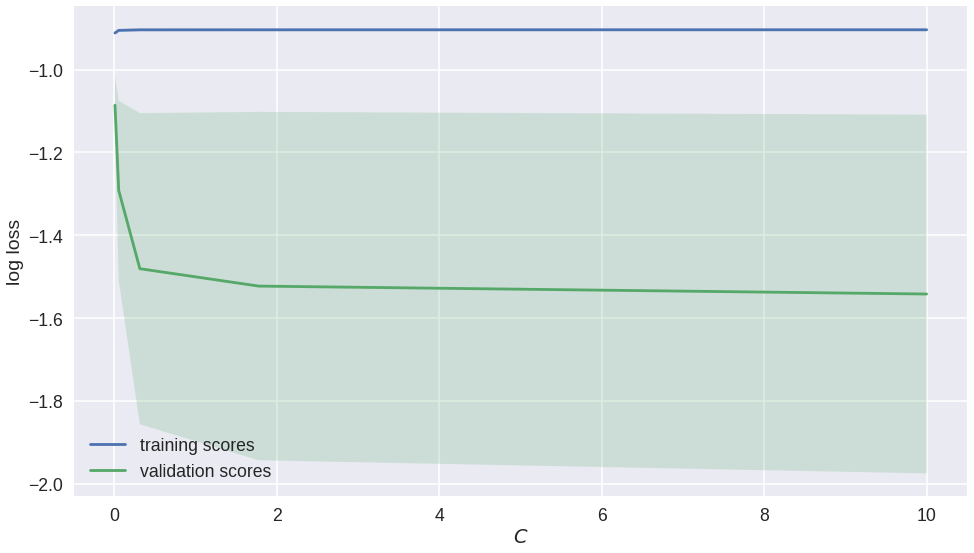

In [0]:
plt.rcParams['figure.figsize'] = 16,9
plot_with_err(C_vals, val_train, label='training scores')
plot_with_err(C_vals, val_test, label='validation scores')
plt.xlabel(r'$C$'); plt.ylabel('log loss')
plt.legend();

На основе анализа кривых валидации можно сделать вывод, что наша модель переобучена, т.к. в LogisticRegression меньшим значениям "C" соответствует большая регуляризация.

#### Построим кривые обучения

In [0]:
from sklearn.metrics import log_loss

In [0]:
log_loss_scorer = make_scorer(lambda y_true, y_pred: log_loss(y_true, y_pred, labels=np.unique(y_true)), needs_proba=True)

In [0]:
clf_logit = LogisticRegression(random_state=17, 
                               n_jobs=4,
                               C=0.01,
                               multi_class='multinomial', 
                               solver='lbfgs')
    
N_train, val_train, val_test = learning_curve(clf_logit,
                                              X_train, y, 
                                              #groups=y,
                                              #train_sizes=train_sizes, 
                                              cv=3,
                                              n_jobs=1, 
                                              verbose=1,
                                              scoring=ndcg_scorer)

[learning_curve] Training set sizes: [ 4920 15991 27062 38133 49204]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.9min finished


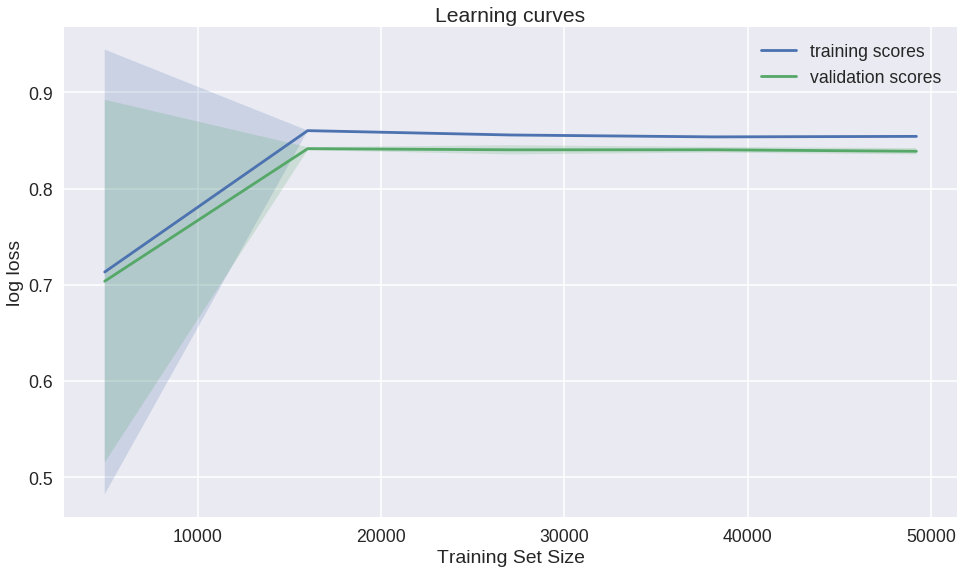

In [0]:
plt.rcParams['figure.figsize'] = 16,9
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('log loss')
plt.title("Learning curves")
plt.legend()

На кривой обучения мы видим, что метрики качества на обучающающей и валидационной выборках сходятся после примерно 15000 наблюдений. Далее они практически не меняются.

### _Градиентный бустинг (XGBoost)_

#### Подбираем базовое количество деревьев

XGBoost имеет большое количество тонких настроек. Вначале мы попробуем подобрать оптимальное количество деревьев (n_estimators) при помощи встроенной функции кросс-валидации xgboost. Из-за ограничения в вычислительных ресурсах мы не будем проверять значения n_estimators больше 100.

In [0]:
# Кастомная реализация метрики NDCG
def ndcg5_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

In [0]:
%%time
xgtrain = xgb.DMatrix(X_train_part, label=y_train_part)

CPU times: user 7 s, sys: 545 ms, total: 7.54 s
Wall time: 7.53 s


In [0]:
param = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'nthread': 8,
    'n_jobs': -1,
    'seed': 17
}

Запускаем встроенную функцию кросс-валидации xgboost

In [0]:
%%time
cvresult = xgb.cv(param, 
                  xgtrain, 
                  num_boost_round=100, 
                  metrics=['mlogloss'], 
                  feval=ndcg5_score, 
                  maximize=True,
                  #nfold=5,
                  seed=17, 
                  early_stopping_rounds=50, 
                  verbose_eval=True)

[0]	train-mlogloss:2.1828+0.00720741	train-ndcg5:0.852269+0.00290595	test-mlogloss:2.18524+0.00754064	test-ndcg5:0.847383+0.00417573
[1]	train-mlogloss:1.98615+0.00769199	train-ndcg5:0.85447+0.00170076	test-mlogloss:1.99041+0.0074323	test-ndcg5:0.849651+0.00268982
[2]	train-mlogloss:1.83552+0.00559728	train-ndcg5:0.855555+0.00157204	test-mlogloss:1.84138+0.00513326	test-ndcg5:0.850278+0.00189241
[3]	train-mlogloss:1.71852+0.0045234	train-ndcg5:0.856208+0.00127341	test-mlogloss:1.72591+0.00422638	test-ndcg5:0.850741+0.00224692
[4]	train-mlogloss:1.62101+0.00288843	train-ndcg5:0.856659+0.000900623	test-mlogloss:1.62995+0.00334457	test-ndcg5:0.850759+0.00210714
[5]	train-mlogloss:1.53771+0.00249872	train-ndcg5:0.85744+0.00077474	test-mlogloss:1.5482+0.00303244	test-ndcg5:0.851472+0.00174419
[6]	train-mlogloss:1.46696+0.00192673	train-ndcg5:0.858303+0.000544104	test-mlogloss:1.47895+0.0025297	test-ndcg5:0.852204+0.00155724
[7]	train-mlogloss:1.40568+0.00226064	train-ndcg5:0.85873+0.0006305

In [0]:
cvresult.shape[0]

100

Из-за особенностей пространства признаков задачи (много разреженных переменных) сделать полноценный поиск оптимальных параметров XGBoost не представляется возможным. Нам не удалось за разумное время посчитать при помощи GridSearch и кросс-валидации на 3 фолда оптимальные параметры, поэтому мы использовали более простую схему ручного перебора - без кросс-валидации, но с оценкой на валидационной (отложенной) выборке. В результате получены следующие "оптимальные" параметры:

#### Прогноз на отложенной выборке

In [0]:
xgb1 = XGBClassifier(
     learning_rate=0.1,
     min_child_weight=1,
     n_estimators=120,
     max_depth=7,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='multi:softprob',
     num_class=12,
     scale_pos_weight=1,
     reg_alpha=0,
     reg_lambda=1,
     nthread=8,
     n_jobs=-1,
     seed=17
)

In [0]:
%%time
xgb1.fit(X_train_part, y_train_part)


CPU times: user 1h 22min 30s, sys: 7.7 s, total: 1h 22min 38s
Wall time: 42min 11s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=8, num_class=12, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=17, silent=True, subsample=0.8)

In [0]:
y_predict = xgb1.predict_proba(X_valid)

In [0]:
%%time
my_ndcg(y_valid, y_predict, k=5)

CPU times: user 163 ms, sys: 1.99 ms, total: 165 ms
Wall time: 166 ms


0.7846899407805021

In [0]:
%%time
xgb1.fit(X_train, y)
y_predict = xgb1.predict_proba(X_test)

CPU times: user 1h 57min 18s, sys: 9.64 s, total: 1h 57min 28s
Wall time: 1h 2s


In [0]:
create_submission(y_predict, indexes, y_enc, 'sub_xgb_100.csv')

### Часть 11. Выводы 

Модели | Score Private LB
--- | ---
Логистической регрессии с параметрами по умолчанию | 0.86283
Логистическая регрессия с параметрами после кроссвалидации | 0.86828
XGBoost|0.88557

В результате применения более сложного семейства моделей - градиентного бустинга - нам удалось повысить качество прогноза на тестовой выборке, однако это было сделано ценой значительно больших вычислительных ресурсов и времени. Целевая метрика получилась довольно высокой 0.88559 (private LB), что говорит о хорошем качестве прогноза. На момент выполнения проекта соревнование на Kaggle уже было завершено, но по текущим показателям в лидерборде наш сабмит находится на 97 месте (top 6%).

Результаты прогноза наиболее вероятной страны первого бронирования позволят оптимизировать показ рекламных баннеров и почтовую рассылку, сделает ее более персонализированной. Это в свою очередь позволит увеличить степень использования сервиса новыми клиентами и снизить среднее время от регистрации до первого бронирования.